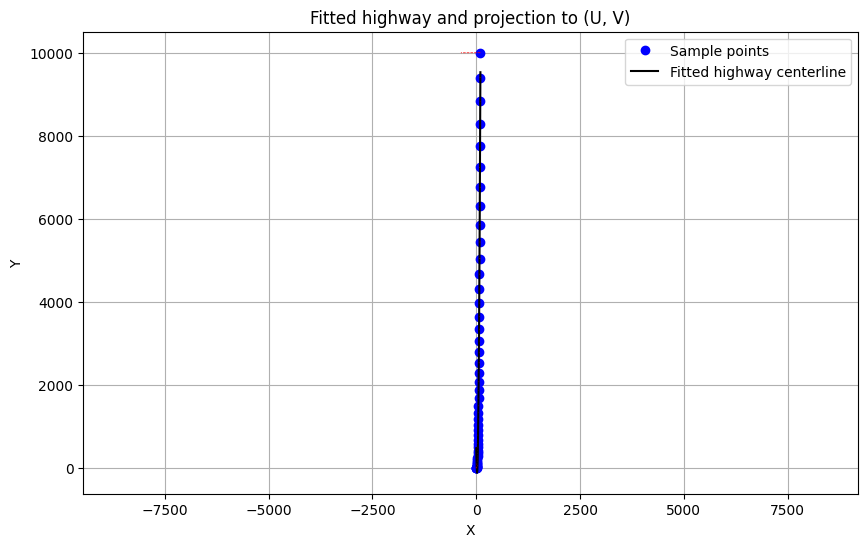

Point 0: U = 467.37, V = -10.87
Point 1: U = 472.72, V = -9.24
Point 2: U = 467.37, V = -7.19
Point 3: U = 467.37, V = -4.91
Point 4: U = 461.91, V = -3.05
Point 5: U = 461.91, V = -0.47
Point 6: U = 450.62, V = 2.15
Point 7: U = 438.85, V = 5.25
Point 8: U = 426.60, V = 6.92
Point 9: U = 407.32, V = 9.60
Point 10: U = 793.89, V = 11.08
Point 11: U = 815.47, V = 10.34
Point 12: U = 853.86, V = 8.62
Point 13: U = 895.26, V = 7.57
Point 14: U = 939.67, V = 7.13
Point 15: U = 996.93, V = 6.37
Point 16: U = 1058.54, V = 5.34
Point 17: U = 1124.48, V = 4.02
Point 18: U = 1206.89, V = 4.40
Point 19: U = 1295.21, V = 4.29
Point 20: U = 1389.43, V = 3.05
Point 21: U = 1489.55, V = 7.22
Point 22: U = 1611.21, V = 3.23
Point 23: U = 1740.58, V = 2.50
Point 24: U = 1877.66, V = 6.60
Point 25: U = 2041.09, V = -5.32
Point 26: U = 2194.55, V = -7.64
Point 27: U = 2376.42, V = -4.12
Point 28: U = 2568.05, V = -6.04
Point 29: U = 2792.41, V = -10.52
Point 30: U = 3004.64, V = -2.37
Point 31: U = 3251

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from scipy.spatial import distance

# ==== STEP 1: Load or simulate sample data along a highway ====
# Example: noisy samples around a curved road (true centerline is y = 0.01*x^2)
np.random.seed(1)
x_data = np.linspace(0, 100, 50)
y_data = 0.01 * x_data**3 + np.random.normal(0, 1.0, size=x_data.shape)

# ==== STEP 2: Fit a polynomial to find the "centerline" ====
degree = 2
coeffs = np.polyfit(x_data, y_data, degree)
poly = np.poly1d(coeffs)

# Centerline points (for U-V transformation)
x_center = np.linspace(x_data.min(), x_data.max(), 500)
y_center = poly(x_center)
centerline = np.column_stack((x_center, y_center))

# ==== STEP 3: Project points to the centerline to compute (U, V) ====
def find_projection_and_uv(point, centerline):
    """
    Project a point onto the centerline and compute U (distance along curve)
    and V (perpendicular distance).
    """
    # Find the closest point on the centerline
    dists = np.linalg.norm(centerline - point, axis=1)
    min_idx = np.argmin(dists)
    proj_point = centerline[min_idx]

    # Compute U: distance along the centerline from start to proj_point
    centerline_segment = centerline[:min_idx+1]
    diffs = np.diff(centerline_segment, axis=0)
    dists_along = np.linalg.norm(diffs, axis=1)
    U = np.sum(dists_along)

    # Compute V: perpendicular distance to the centerline
    V = np.linalg.norm(point - proj_point)

    # Determine side (left/right of road centerline)
    # Using local tangent vector and cross product
    if min_idx > 0:
        tangent = centerline[min_idx] - centerline[min_idx - 1]
    else:
        tangent = centerline[min_idx + 1] - centerline[min_idx]
    normal = np.array([-tangent[1], tangent[0]])  # Rotate tangent 90°
    direction = np.dot(point - proj_point, normal)
    V *= np.sign(direction)

    return U, V

# Compute U, V for all original points
UV = np.array([find_projection_and_uv(np.array([x, y]), centerline) for x, y in zip(x_data, y_data)])
U_vals, V_vals = UV[:, 0], UV[:, 1]

# ==== STEP 4: Plot ====
plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, 'bo', label='Sample points')
plt.plot(x_center, y_center, 'k-', label='Fitted highway centerline')
for i in range(len(x_data)):
    proj_x = x_data[i] - V_vals[i] * np.sin(np.arctan2(np.polyder(poly)(x_data[i]), 1))
    proj_y = y_data[i] - V_vals[i] * np.cos(np.arctan2(np.polyder(poly)(x_data[i]), 1))
    plt.plot([x_data[i], proj_x], [y_data[i], proj_y], 'r--', lw=0.5)

plt.axis('equal')
plt.legend()
plt.title("Fitted highway and projection to (U, V)")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

# ==== Output UV coordinates ====
for i in range(len(U_vals)):
    print(f"Point {i}: U = {U_vals[i]:.2f}, V = {V_vals[i]:.2f}")



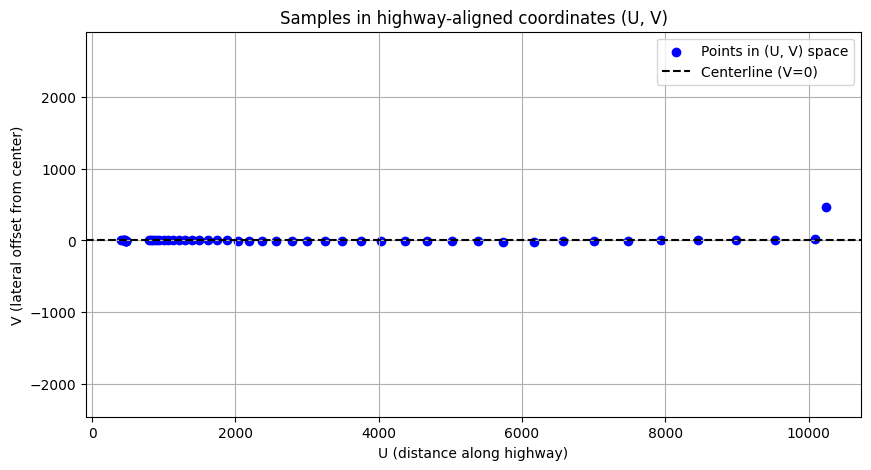

In [5]:
# ==== STEP 5: Plot in the highway referential (U, V) ====
plt.figure(figsize=(10, 5))
plt.scatter(U_vals, V_vals, c='blue', label='Points in (U, V) space')
plt.axhline(0, color='k', linestyle='--', label='Centerline (V=0)')
plt.title("Samples in highway-aligned coordinates (U, V)")
plt.xlabel("U (distance along highway)")
plt.ylabel("V (lateral offset from center)")
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()
